# VGG19 Model

## Import Library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19

## Load Data

In [2]:
# Path to your processed dataset (output dari kode pertama)
base_dir = 'D:/CNN/dataset/cropped/'
train_data = 'D:/CNN/dataset/splited/train/'
val_data = 'D:/CNN/dataset/splited/val/'
test_data = 'D:/CNN/dataset/splited/test/'

In [3]:
# Hitung jumlah folder yang ada di dataset_processed
def count_subdirectories(base_directory):
    # Hitung jumlah folder langsung di dalam direktori
    num_folders = len([name for name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, name))])
    return num_folders

# Hitung jumlah folder
num_folders = count_subdirectories(base_dir)

print(f"Jumlah folder di dalam {base_dir}: {num_folders}")

Jumlah folder di dalam D:/CNN/dataset/cropped/: 21


## Image Data Generator

In [4]:
# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    # validation_split=0.3
)

In [5]:
# Create data generators
train_generator = datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    # subset='training'
)

val_generator = datagen.flow_from_directory(
    val_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    # subset='validation'
)
test_generator = datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 219 images belonging to 21 classes.
Found 104 images belonging to 21 classes.


Found 50 images belonging to 21 classes.


## Pre-Trained VGG19 Model

In [6]:
# Load the pre-trained VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [7]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Add custom fully connected layers on top of the pre-trained model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_folders, activation='softmax')(x)

In [9]:
# Create the final model
model = Model(base_model.input, x)

## Final Model Compilation and Training

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
# Learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.000003
)

In [12]:
saveBestModelVgg19 = tf.keras.callbacks.ModelCheckpoint('best_model_vgg19.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [13]:
model_file_path = 'D:/CNN/Source/best_model_vgg19.h5'
if os.path.exists(model_file_path):
    os.remove(model_file_path)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[saveBestModelVgg19]
)

Epoch 1/200


7/7 [==============================] - ETA: 0s - loss: 7.2938 - accuracy: 0.0913
Epoch 1: val_accuracy improved from -inf to 0.18269, saving model to best_model_vgg19.h5


c:\Users\anira\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 75s 11s/step - loss: 7.2938 - accuracy: 0.0913 - val_loss: 3.0938 - val_accuracy: 0.1827
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 3.0086 - accuracy: 0.2146
Epoch 2: val_accuracy improved from 0.18269 to 0.46154, saving model to best_model_vgg19.h5
7/7 [==============================] - 74s 11s/step - loss: 3.0086 - accuracy: 0.2146 - val_loss: 2.1906 - val_accuracy: 0.4615
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 2.2026 - accuracy: 0.3288
Epoch 3: val_accuracy improved from 0.46154 to 0.50962, saving model to best_model_vgg19.h5
7/7 [==============================] - 77s 12s/step - loss: 2.2026 - accuracy: 0.3288 - val_loss: 2.0576 - val_accuracy: 0.5096
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 2.1120 - accuracy: 0.3562
Epoch 4: val_accuracy improved from 0.50962 to 0.64423, saving model to best_model_vgg19.h5
7/7 [==============================] - 76s 11s/step - loss: 2

## Model Evaluate

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def evaluate(model):
    test_generator = datagen.flow_from_directory(
        test_data,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
    )


    num_of_test_samples = len(test_generator.filenames)
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    true_labels = test_generator.classes
    num_classes = len(test_generator.class_indices)
    
    accuracy = accuracy_score(true_labels, y_pred)

    print('\nConfusion Matrix\n')
    print(confusion_matrix(test_generator.classes, y_pred))

    print('\nAccuracy\n')
    print(accuracy)

    print('\n\nClassification Report\n')
    target_names = [os.path.basename(cls) for cls in test_generator.class_indices.keys()]
    labels = range(len(target_names))  # Menggunakan range jumlah target_names
    class_report = classification_report(true_labels, y_pred, labels=range(num_classes), target_names=target_names)
    print(class_report)


In [16]:
# Evaluate the model
evaluate(model)

Found 50 images belonging to 21 classes.
2/2 [==============================] - 29s 10s/step

Confusion Matrix

[[1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

c:\Users\anira\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anira\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anira\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Plotting Review

In [17]:
# Plotting the evaluation history
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

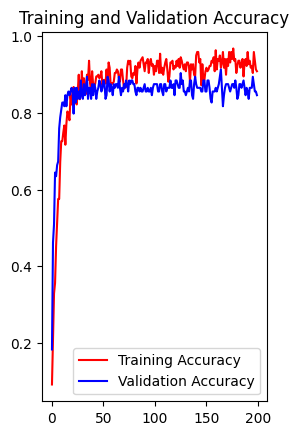

In [18]:
# Accuracy plot
plt.subplot(1, 2, 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

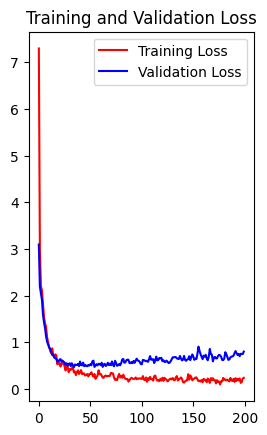

In [19]:
# Loss plot
plt.subplot(1, 2, 2)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

In [20]:
from tensorflow.keras.models import load_model
# Lokasi file model yang disimpan
saved_model_path = 'D:/CNN/Source/best_model_vgg19.h5'

# Memuat model yang telah disimpan
loaded_model = load_model(saved_model_path)

# Jika kamu ingin mengecek struktur model
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:

# Kemudian, gunakan model yang telah dimuat untuk prediksi atau evaluasi
evaluate(loaded_model)

Found 50 images belonging to 21 classes.


2/2 [==============================] - 24s 9s/step

Confusion Matrix

[[1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 

c:\Users\anira\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anira\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anira\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## File H5

In [34]:
# # Simpan model ke dalam file H5
# model.save('VGG19model.h5')
#
# # Cetak pesan bahwa penyimpanan telah berhasil
# print("Model berhasil disimpan ke dalam file H5.")

In [22]:
train_class_indices = train_generator.class_indices
classes = list(train_class_indices.keys())

Jumlah kelas dalam direktori: 21
Nama-nama kelas:
Kelas ke-1: 2007051019
Kelas ke-2: 2017051001
Kelas ke-3: 2017051009
Kelas ke-4: 2017051013
Kelas ke-5: 2017051015
Kelas ke-6: 2017051017
Kelas ke-7: 2017051051
Kelas ke-8: 2017051056
Kelas ke-9: 2017051058
Kelas ke-10: 2017051083
Kelas ke-11: 2057051001
Kelas ke-12: 2057081057
Kelas ke-13: 2117051009
Kelas ke-14: 2117051019
Kelas ke-15: 2117051027
Kelas ke-16: 2117051043
Kelas ke-17: 2117051048
Kelas ke-18: 2117051050
Kelas ke-19: 2117051095
Kelas ke-20: 2157051001
Kelas ke-21: 2157051006

Jumlah kelas dalam model: 21

Hasil Prediksi pada Direktori Testing:


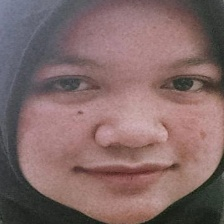

1/1 [==============================] - 1s 1s/step
File: face_2007051019_17.jpg, Predicted Class: 2007051019


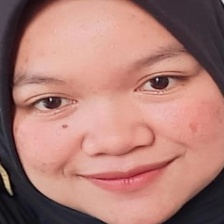

1/1 [==============================] - 1s 838ms/step
File: face_2007051019_12.jpg, Predicted Class: 2017051051


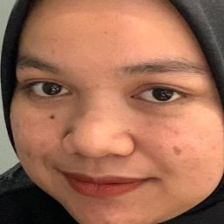

1/1 [==============================] - 1s 575ms/step
File: face_2007051019_1.jpg, Predicted Class: 2017051056


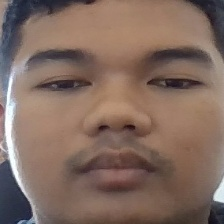

1/1 [==============================] - 1s 701ms/step
File: face_2017051001_5.jpg, Predicted Class: 2017051001


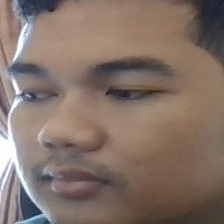

1/1 [==============================] - 1s 728ms/step
File: face_2017051001_10.jpg, Predicted Class: 2017051001


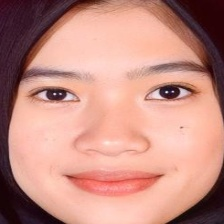

1/1 [==============================] - 1s 632ms/step
File: face_2017051009_10.jpg, Predicted Class: 2017051051


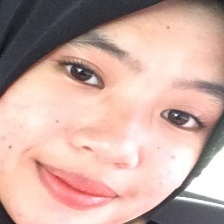

1/1 [==============================] - 2s 2s/step
File: face_2017051009_1.jpg, Predicted Class: 2017051083


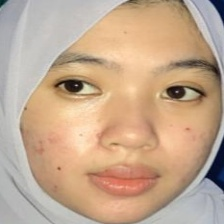

1/1 [==============================] - 1s 1s/step
File: face_2017051009_7.jpg, Predicted Class: 2017051056


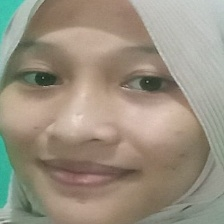

1/1 [==============================] - 1s 936ms/step
File: face_2017051013_12.jpg, Predicted Class: 2017051013


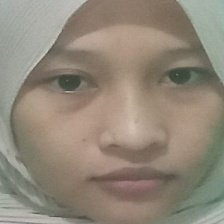

1/1 [==============================] - 1s 1s/step
File: face_2017051013_1.jpg, Predicted Class: 2017051013


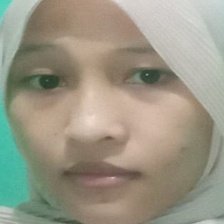

1/1 [==============================] - 1s 1s/step
File: face_2017051013_17.jpg, Predicted Class: 2017051013


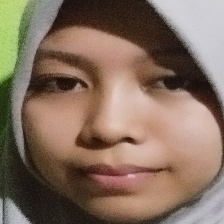

1/1 [==============================] - 1s 1s/step
File: face_2017051015_12.jpg, Predicted Class: 2017051015


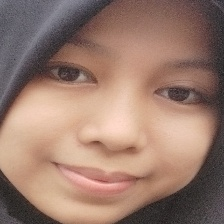

1/1 [==============================] - 1s 670ms/step
File: face_2017051015_9.jpg, Predicted Class: 2017051015


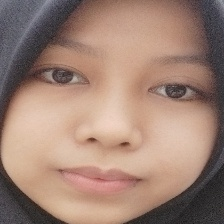

1/1 [==============================] - 1s 626ms/step
File: face_2017051015_1.jpg, Predicted Class: 2017051015


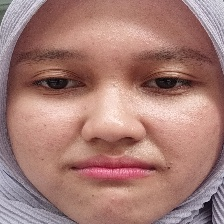

1/1 [==============================] - 1s 609ms/step
File: face_2017051017_1.jpeg, Predicted Class: 2017051017


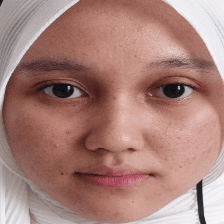

1/1 [==============================] - 0s 475ms/step
File: face_2017051017_12.png, Predicted Class: 2017051017


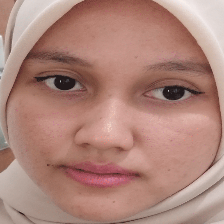

1/1 [==============================] - 1s 597ms/step
File: face_2017051017_17.png, Predicted Class: 2017051017


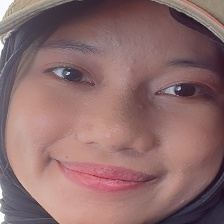

1/1 [==============================] - 1s 559ms/step
File: face_2017051051_12.jpg, Predicted Class: 2017051051


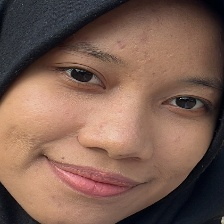

1/1 [==============================] - 1s 628ms/step
File: face_2017051051_1.jpg, Predicted Class: 2017051083


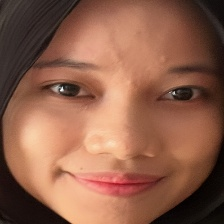

1/1 [==============================] - 1s 562ms/step
File: face_2017051051_17.jpg, Predicted Class: 2017051051


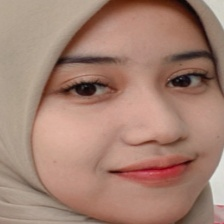

1/1 [==============================] - 1s 996ms/step
File: face_2017051056_5.jpg, Predicted Class: 2017051056


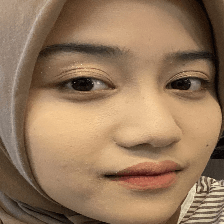

1/1 [==============================] - 1s 927ms/step
File: face_2017051056_11.png, Predicted Class: 2017051056


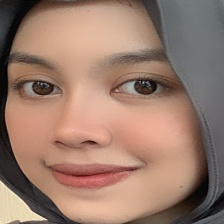

1/1 [==============================] - 1s 915ms/step
File: face_2017051058_1.jpg, Predicted Class: 2017051056


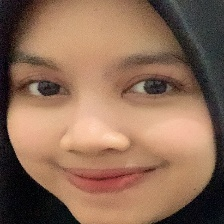

1/1 [==============================] - 1s 1s/step
File: face_2017051058_12.jpg, Predicted Class: 2017051058


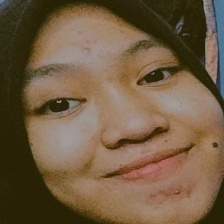

1/1 [==============================] - 1s 1s/step
File: face_2017051083_10.jpg, Predicted Class: 2157051006


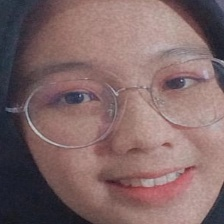

1/1 [==============================] - 1s 1s/step
File: face_2057051001_12.jpg, Predicted Class: 2057051001


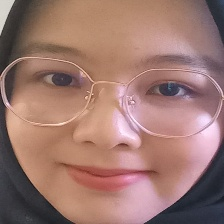

1/1 [==============================] - 1s 633ms/step
File: face_2057051001_1.jpg, Predicted Class: 2057051001


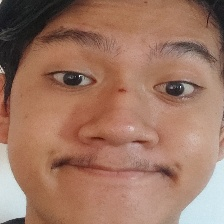

1/1 [==============================] - 1s 671ms/step
File: face_2057081057_12.jpg, Predicted Class: 2057081057


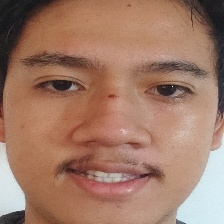

1/1 [==============================] - 1s 557ms/step
File: face_2057081057_1.jpg, Predicted Class: 2057081057


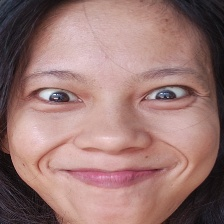

1/1 [==============================] - 1s 1s/step
File: face_2117051009_12.jpg, Predicted Class: 2117051009


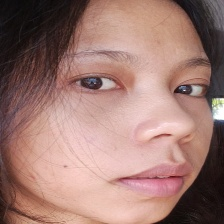

1/1 [==============================] - 1s 1s/step
File: face_2117051009_1.jpg, Predicted Class: 2017051056


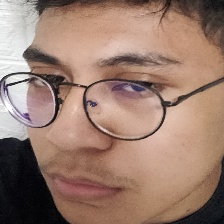

1/1 [==============================] - 1s 1s/step
File: face_2117051019_5.jpg, Predicted Class: 2117051019


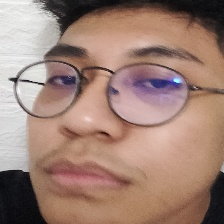

1/1 [==============================] - 1s 1s/step
File: face_2117051019_10.jpg, Predicted Class: 2117051019


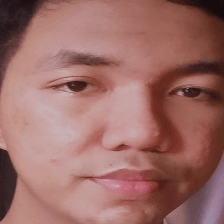

1/1 [==============================] - 2s 2s/step
File: face_2117051027_1.png, Predicted Class: 2117051027


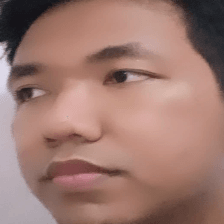

1/1 [==============================] - 2s 2s/step
File: face_2117051027_12.png, Predicted Class: 2117051027


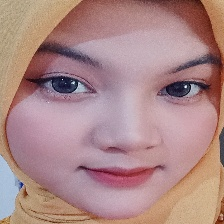

1/1 [==============================] - 1s 1s/step
File: face_2117051043_17.jpg, Predicted Class: 2017051017


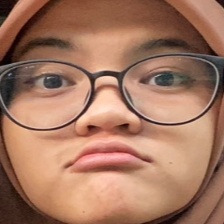

1/1 [==============================] - 1s 524ms/step
File: face_2117051043_1.jpg, Predicted Class: 2117051095


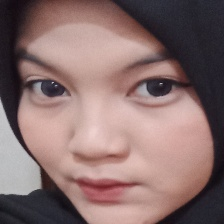

1/1 [==============================] - 1s 513ms/step
File: face_2117051043_12.jpg, Predicted Class: 2117051043


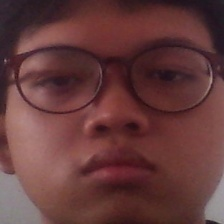

1/1 [==============================] - 1s 510ms/step
File: face_2117051048_10.jpg, Predicted Class: 2117051048


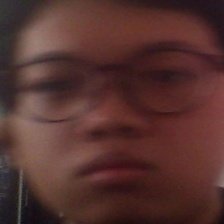

1/1 [==============================] - 0s 494ms/step
File: face_2117051048_9.jpg, Predicted Class: 2117051048


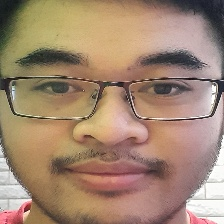

1/1 [==============================] - 1s 604ms/step
File: face_2117051050_1.jpg, Predicted Class: 2117051050


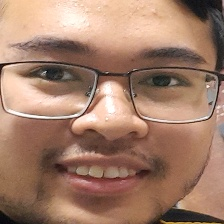

1/1 [==============================] - 1s 657ms/step
File: face_2117051050_20.jpg, Predicted Class: 2117051050


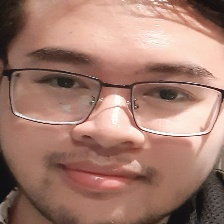

1/1 [==============================] - 1s 701ms/step
File: face_2117051050_12(1).jpg, Predicted Class: 2117051050


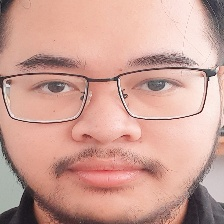

1/1 [==============================] - 1s 670ms/step
File: face_2117051050_5.jpg, Predicted Class: 2117051050


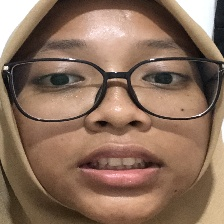

1/1 [==============================] - 1s 607ms/step
File: face_2117051095_12.jpg, Predicted Class: 2117051095


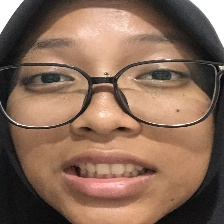

1/1 [==============================] - 1s 601ms/step
File: face_2117051095_1.jpg, Predicted Class: 2117051095


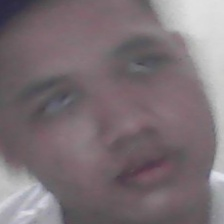

1/1 [==============================] - 1s 797ms/step
File: face_2157051001_10.jpg, Predicted Class: 2157051001


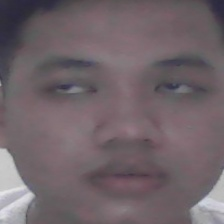

1/1 [==============================] - 1s 539ms/step
File: face_2157051001_5.jpg, Predicted Class: 2157051001


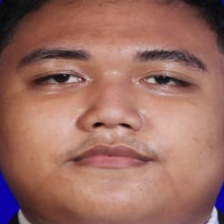

1/1 [==============================] - 1s 702ms/step
File: face_2157051006_1.jpg, Predicted Class: 2157051006


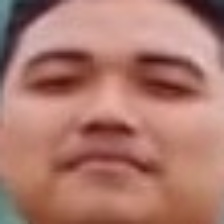

1/1 [==============================] - 1s 706ms/step
File: face_2157051006_12.jpg, Predicted Class: 2157051006


In [23]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os

import random

def count_classes_and_show_names(base_directory, model=None, test_directory=None):
    # Penggunaan array classes yang telah diperbarui
    num_folders = len(classes)

    print(f"Jumlah kelas dalam direktori: {num_folders}")

    # Tampilkan nama-nama kelas
    print("Nama-nama kelas:")
    for idx, folder in enumerate(classes):
        print(f"Kelas ke-{idx + 1}: {folder}")

    if model and test_directory:
        # Jumlah kelas dalam model
        num_classes_model = model.output_shape[-1]
        print(f"\nJumlah kelas dalam model: {num_classes_model}")

        # Buat dictionary untuk memetakan indeks kelas dengan nama folder
        class_mapping = {i: folder for i, folder in enumerate(classes)}

        # Melakukan prediksi pada direktori testing
        print("\nHasil Prediksi pada Direktori Testing:")

        for root, dirs, files in os.walk(test_directory):
            # Iterasi melalui setiap sub-direktori dalam test_directory
            for folder in dirs:
                folder_path = os.path.join(root, folder)

                # Mengambil list nama file dalam sub-direktori saat ini
                sub_files = os.listdir(folder_path)

                # Mengacak urutan file dalam sub-direktori
                random.shuffle(sub_files)

                # Iterasi melalui setiap file dalam sub-direktori saat ini
                for file in sub_files:
                    img_path = os.path.join(folder_path, file)

                    # Pastikan yang di-load adalah file gambar
                    if os.path.isfile(img_path):
                        # Load gambar
                        img = Image.open(img_path)
                        display(img)  # Menampilkan gambar

                        # Load gambar, ubah ukuran menjadi 224x224 (sesuaikan dengan model), dan rescale ke rentang 0-1
                        img = load_img(img_path, target_size=(224, 224))
                        img_array = img_to_array(img)
                        img_array = np.expand_dims(img_array, axis=0) / 255.0

                        # Lakukan prediksi menggunakan model
                        prediction = model.predict(img_array)

                        # Dapatkan indeks kelas prediksi dari hasil prediksi
                        predicted_class_index = np.argmax(prediction)

                        # Gunakan dictionary mapping untuk mendapatkan nama kelas
                        predicted_class = class_mapping[predicted_class_index]

                        print(f"File: {file}, Predicted Class: {predicted_class}")

        return num_folders, classes, num_classes_model

    return num_folders, classes

# Menggunakan fungsi count_classes_and_show_names untuk mendapatkan informasi tentang kelas dalam direktori dan melakukan prediksi pada direktori testing
num_classes, class_names, num_classes_model = count_classes_and_show_names(train_data, loaded_model, test_data)
